In [208]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [209]:
img = cv2.imread('./data/test_images/greta_2.png')
img.shape

(420, 620, 3)

### Data Cleaning

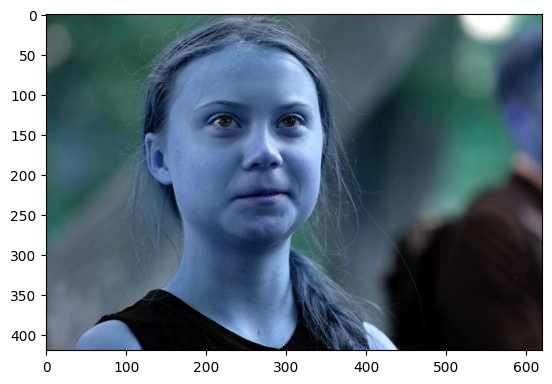

In [210]:
plt.imshow(img)

In [211]:
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
gray.shape

(420, 620)

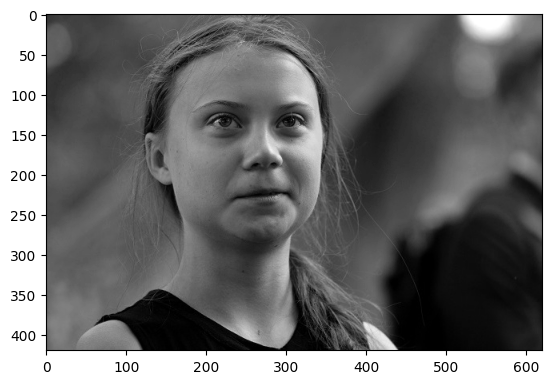

In [212]:
plt.imshow(gray,cmap='gray')

In [213]:
face_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_eye.xml')

In [214]:
faces = face_cascade.detectMultiScale(gray,1.3,5)
faces[0]

array([151,  52, 226, 226], dtype=int32)

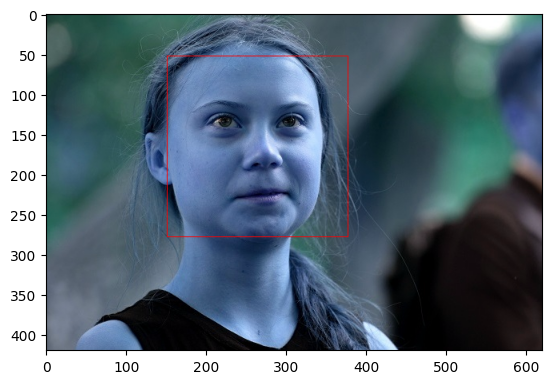

In [215]:
(x,y,w,h) = faces[0]
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),1)
plt.imshow(face_img)

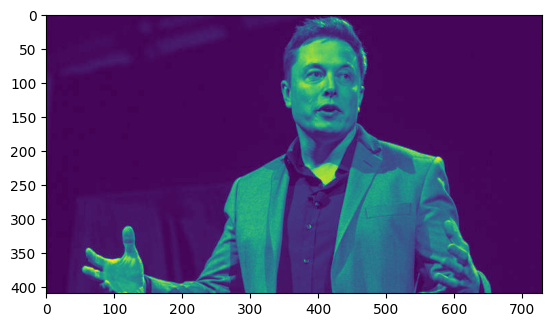

In [216]:
img = cv2.imread('./data/test_images/elon_1.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

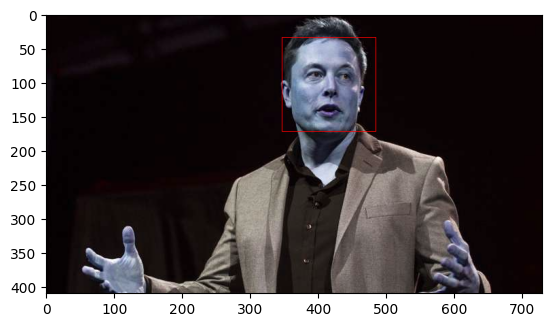

In [218]:
faces = face_cascade.detectMultiScale(gray,1.3,5)
(x,y,w,h) = faces[0]
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),1)
plt.imshow(face_img)

In [219]:
def get_cropped_img_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    cropped_faces = []
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            cropped_faces.append(roi_color)

    return cropped_faces


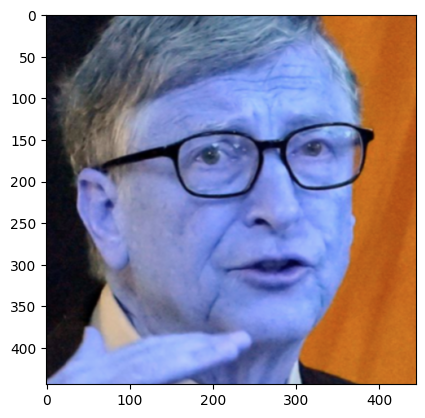

In [221]:
imgs = get_cropped_img_if_2_eyes('./data/test_images/elon_bill.png')
# for img in imgs:
plt.imshow(imgs[0])

In [222]:
person_dir = '/home/rohit/Desktop/Machine Learning/Projects/Celebrity Image Classification/model/data/persons/'
cropped_dir = '/home/rohit/Desktop/Machine Learning/Projects/Celebrity Image Classification/model/data/cropped/'
import os


In [223]:
celebrity_file_names_dict = {}
for entry in os.scandir(person_dir):
    person = entry.path.split('/')[-1]
    print(person)
    celebrity_file_names_dict[person] = []
    for img_entry in os.scandir(entry.path):
        celebrity_file_names_dict[person].append(img_entry.path)

sundar_pichai
greta_thunberg
ratan_tata
elon_musk
suchin_tendulkar


In [224]:
from warnings import filterwarnings
filterwarnings('ignore')

In [132]:
for person, _imgs in celebrity_file_names_dict.items():
    print(person)
    for count, img in enumerate(_imgs):
        cropped_imgs = get_cropped_img_if_2_eyes(img)

        cropped_person_dir = f'{cropped_dir}{person}/'
        if not(os.path.exists(cropped_person_dir)):
            os.mkdir(cropped_person_dir)

        if len(cropped_imgs) > 0:
            for cnt, cropped in enumerate(cropped_imgs):
                blur_val = cv2.Laplacian(cropped,cv2.CV_64F).var()
                if blur_val > 120:
                    cropped_file = f'{person}_{count}_{cnt}.png'
                    cv2.imwrite(
                        cropped_person_dir+cropped_file,
                        cropped
                    )
        print(f'{len(_imgs)} / {count}',end='\r')


sundar_pichai
greta_thunberg
ratan_tata
sachin_tendulkar
elon_musk


In [225]:
'''Updating file_name_dict variable'''

celebrity_file_names_dict = {}
for entry in os.scandir(cropped_dir):
    person = entry.path.split('/')[-1]
    print(person)
    celebrity_file_names_dict[person] = []
    for img_entry in os.scandir(entry.path):
        celebrity_file_names_dict[person].append(img_entry.path)

sundar_pichai
greta_thunberg
ratan_tata
sachin_tendulkar
elon_musk


In [226]:
class_dict = {}
for count,celeb_name in enumerate(celebrity_file_names_dict.keys()):
    class_dict[celeb_name] = count
class_dict

{'sundar_pichai': 0,
 'greta_thunberg': 1,
 'ratan_tata': 2,
 'sachin_tendulkar': 3,
 'elon_musk': 4}

In [227]:
from wavelet import w2d

In [228]:
X = []
y = []

for celeb_name,train_files in celebrity_file_names_dict.items():
    for train_file in train_files:
        img = cv2.imread(train_file)
        scalled_raw_img = cv2.resize(img,(32,32))
        scalled_img_har = w2d(scalled_raw_img,'db1',5)
        combined_img = np.vstack((
            scalled_raw_img.reshape(32*32*3,1),
            scalled_img_har.reshape(32*32,1)
        ))
        X.append(combined_img)
        y.append(class_dict[celeb_name])

X = np.array(X)
y = np.array(y)

In [229]:
X.shape

(889, 4096, 1)

In [230]:
len(X),len(X[0])

(889, 4096)

In [231]:
X = X.reshape(len(X),len(X[0])).astype(float)
X.shape

(889, 4096)

In [232]:
y.shape

(889,)

## Train model

In [233]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [234]:
X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.2
)
pipe = Pipeline([
    ('scaler',MinMaxScaler()),
    ('svc',SVC(C=10))
])
pipe.fit(X_train,y_train)
pipe.score(X_test,y_test)

0.9157303370786517

In [235]:
print(classification_report(y_test,pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        38
           1       0.90      0.92      0.91        59
           2       1.00      0.96      0.98        25
           3       0.85      0.96      0.90        23
           4       0.88      0.88      0.88        33

    accuracy                           0.92       178
   macro avg       0.92      0.92      0.92       178
weighted avg       0.92      0.92      0.92       178



## GridSearchCV

In [236]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd
from warnings import filterwarnings
filterwarnings('ignore')

In [242]:
model_params = {
    'svm':{
        'model': SVC(gamma='auto',probability=False),
        'params':{
            'svc__C': [1,5,10,50],
            'svc__kernel':['rbf','linear','poly']
        }
    },
    'random_forest':{
        'model': RandomForestClassifier(),
        'params':{
            'randomforestclassifier__n_estimators' : [20,50,100],
            'randomforestclassifier__criterion' :['gini','entropy']
        }
    },
    'logistic_regression':{
        'model': LogisticRegression(solver='liblinear',max_iter=500),
        'params': {
            'logisticregression__penalty': ['l1','l2'],
            'logisticregression__C': [1,5,10],
        }
    }
}


In [ ]:
scores = []
best_estimators = {}
for model_name,mp in model_params.items():
    print(model_name)
    pipe = make_pipeline(MinMaxScaler(),mp['model'])
    clf = GridSearchCV(pipe,mp['params'],cv=5,return_train_score=False)
    print('fitting..[start]')
    clf.fit(X_train,y_train)
    print('fitting..[stop]')
    scores.append({
        'model':model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[model_name] = clf.best_estimator_
    print('done')


In [197]:
df = pd.DataFrame(scores)
df

,model,best_score,best_params
0,svm,0.871998,"{'svc__C': 50, 'svc__kernel': 'rbf'}"
1,random_forest,0.831272,"{'randomforestclassifier__criterion': 'gini', ..."
2,logistic_regression,0.863548,"{'logisticregression__C': 1, 'logisticregressi..."
3,naive_bayes,0.604875,{}


In [198]:
'''
for hypertuning using validation set and to test the perfomance we use X_test
'''
best_estimators

{'svm': Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                 ('svc', SVC(C=50, gamma='auto'))]),
 'random_forest': Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                 ('randomforestclassifier', RandomForestClassifier())]),
 'logistic_regression': Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, max_iter=500, solver='liblinear'))]),
 'naive_bayes': Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('gaussiannb', GaussianNB())])}

In [199]:
best_estimators['svm'].score(X_test,y_test)

0.9269662921348315

In [200]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.9325842696629213

### Choosing SVM

In [249]:
model = SVC(C=50,kernel='rbf',probability=True)
model.fit(X_train,y_train)

SVC(C=50, probability=True)

In [250]:
model.score(X_test,y_test)

0.9157303370786517

In [251]:
model.predict_proba(X_test)

array([[6.60001662e-02, 5.69887661e-02, 5.46873837e-01, 4.47776611e-02,
        2.85359570e-01],
       [2.88446738e-01, 2.16967437e-01, 2.55594368e-01, 2.34528799e-01,
        4.46265845e-03],
       [7.74583245e-02, 6.96077305e-01, 5.37665356e-02, 2.87019052e-02,
        1.43995929e-01],
       [2.98004144e-03, 5.45683245e-03, 1.73608242e-03, 9.89487710e-01,
        3.39333416e-04],
       [9.87897612e-01, 6.87950032e-04, 9.06733375e-03, 2.11367050e-03,
        2.33434114e-04],
       [6.42816326e-04, 1.19255923e-03, 9.95665733e-01, 1.75675746e-03,
        7.42133576e-04],
       [7.01086258e-05, 9.86277059e-01, 1.91749484e-03, 7.50700704e-03,
        4.22833066e-03],
       [2.54110533e-04, 1.85302675e-03, 5.95410922e-04, 1.13709507e-03,
        9.96160357e-01],
       [9.74839726e-01, 4.57779144e-04, 5.20266554e-03, 1.89991914e-02,
        5.00638319e-04],
       [3.75814056e-04, 1.85937195e-03, 9.09996679e-04, 8.30379275e-04,
        9.96024438e-01],
       [4.56894795e-04, 1.7964

In [252]:
best_clf = model

In [253]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [254]:
preds = best_clf.predict(X_test)
preds

array([2, 0, 1, 3, 0, 2, 1, 4, 0, 4, 4, 3, 1, 3, 1, 4, 3, 0, 1, 4, 0, 2,
       1, 0, 4, 1, 1, 2, 3, 0, 1, 3, 4, 1, 1, 1, 1, 1, 4, 1, 3, 3, 0, 1,
       3, 0, 2, 1, 3, 3, 0, 3, 0, 2, 1, 0, 1, 0, 1, 1, 1, 3, 4, 1, 3, 1,
       4, 3, 1, 1, 4, 1, 2, 0, 4, 3, 2, 1, 0, 2, 4, 0, 1, 2, 2, 3, 0, 4,
       0, 3, 0, 3, 1, 4, 4, 1, 3, 4, 1, 1, 4, 4, 2, 1, 0, 1, 0, 1, 3, 1,
       1, 2, 2, 0, 1, 4, 1, 0, 4, 1, 0, 1, 1, 3, 0, 1, 2, 2, 4, 3, 4, 3,
       4, 2, 1, 4, 1, 0, 2, 2, 1, 1, 0, 0, 2, 4, 2, 0, 0, 1, 0, 4, 1, 1,
       0, 2, 1, 4, 3, 0, 1, 1, 1, 3, 4, 0, 2, 0, 1, 1, 1, 4, 2, 4, 1, 4,
       1, 4])

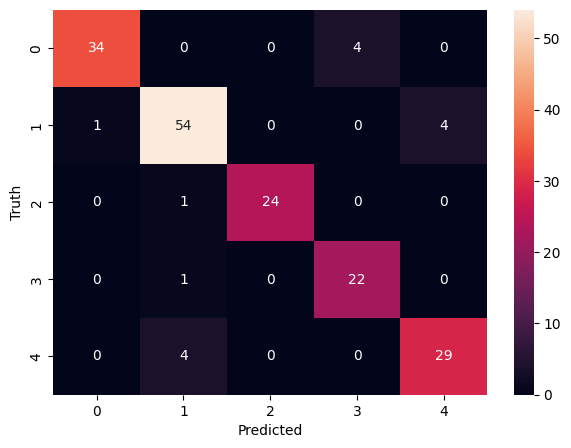

In [255]:
cmap = confusion_matrix(y_test,preds)
plt.figure(figsize=(7,5))
sn.heatmap(cmap,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [256]:
class_dict

{'sundar_pichai': 0,
 'greta_thunberg': 1,
 'ratan_tata': 2,
 'sachin_tendulkar': 3,
 'elon_musk': 4}

## Exporting model

In [257]:
import joblib
joblib.dump(best_clf,'model_svm.jb')

['model_svm.jb']

In [258]:
import json
with open('class_dict.json','w') as f:
    f.write(json.dumps(class_dict))